## From Perceptrons to Neural Nets

Johann Mitloehner, 2017

This text provides a short introduction to machine learning using neural nets with
some emphasis on data acquisition, preparation, and exploration via reports and plotting
for the benefit of data science students.

Python is used in the examples, and various unique features of this programming language are pointed out for
readers unfamiliar with Python, but with some background in other languages such as C or Java.

### The Iris Data Set

The UCI ML repository [5] contains a small data set on three species of Iris plants 
under the URL 

https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

Since we only need to download the file once we use the web browser to download
interactively and save to the current directory under the filename `iris.data`.
Then use your favorite text editor to inspect the contents of the file.

<!---
Alternatively, the code below shows how to acquire data files dynamically:

    import urllib2
    response = urllib2.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
    html = response.read()
--->

$\bigstar$ When processing a data file from any source, always check the contents of the file, either interactively
in a text editor or spreadsheet, or within your program. Never rely on the data to correspond to an advertised
format.

The data file is not yet in a format suitable for processing: first we need to
strip whitespace and split into comma separated fields. The code below reads the data
from the file `iris.data` in the current directory and puts it into a variable `irisdata`.

Sadly, the file on the UCI site contains some empty lines at the end. The condition
`if line.strip()` omits them.

Note that indexing starts at 0 in
Python, just as in C and Java; `irisdata[0]` denotes the first item. 
However, some additional indexing features are available, such as
`irisdata[-1]` which denotes the last item. 

In [57]:
# Iris data set from UCI ML repository
irisdata = [ line.strip().split(",") for line in open("iris.data") if line.strip() ] 
print len(irisdata)
print irisdata[0]
print irisdata[50]
print irisdata[-1]

150
['5.1', '3.5', '1.4', '0.2', 'Iris-setosa']
['7.0', '3.2', '4.7', '1.4', 'Iris-versicolor']
['5.9', '3.0', '5.1', '1.8', 'Iris-virginica']


There are 50 observations for each species, making a total of 150.
We learn from the data description on the UCI website that columns 0 and 2 contain 
the sepal and petal length of each observation, measured in cm.
Columns 1 and 3 contain the corresponding widths which we will ignore here.

Sepals are leaves between the petals of many flowers; they are usually green and serve 
as support and protection for the petals. In the two species Iris setosa and versicolor the
characteristic lengths of sepals and petals can be used for identification.

We want to generate two data sets, so we define a function to avoid code duplication:

- sep contains observations of Iris setosa and Iris versicolor 
- nonsep contains Iris versicolor and Iris virginica

We will use Numpy arrays to hold the data, which provides several advantages:

- we can use the handy Numpy utility functions
- we get superior performance compared to standard Python arrays
- if a suitable linear algebra library is present in the Python installation then
  all cores in a multi-core system are used for matrix-vector multiplications, resulting in an additional performance gain. 

In [58]:
# select sepal and petal length from Iris data
import numpy as np
def select(data, fr, to, species):
    X = np.array([ [ 1.0, float(line[0]), float(line[2]) ] for line in irisdata[fr:to] ])
    y = np.where([ x[4] == species for x in irisdata[fr:to] ], 0, 1)
    return X, y

# setosa & versicolor: linearly separable
sep = select(irisdata, 0, 100, 'Iris-setosa')

# versicolor & virginica: not linearly separable
nonsep = select(irisdata, 50, 150, 'Iris-versicolor')

Note that Python functions can return more than one result; the select function returns matrix X and vector y
in a structure called a *tuple*. 

Matrix X contains rows of observations for sepal and petal lenghts as floating point numbers; 
for each observation the constant 1.0 is added as the first element, followed by the observed values. 
The added constant simplifies notation and code in the examples below.

Vector y contains the species for each observation, coded as 0 and 1. The Numpy function `where()` achieves this.

We start with the first set; since the structure sep is a two-element tuple we assign X and y simultaneously.

X[:3] denotes the first three lines of matrix X. Conveniently, X[-3:] denotes
that last 3 lines.

We can see that each line of X indeed
contains one observation; each element of y contains the corresponding species, coded as 0 or 1. Our data
starts with the setosa observations, followed by the versicolor.

$\bigstar$ It is always a good idea to print some samples of the data once it has been prepared for processing, to see
whether everything looks the way we intended. In real-world applications a lot more has to be done at this stage
to ensure proper data preparation.

In [59]:
X, y = sep
print X[:3]
print y[:3]
print X[-3:]
print y[-3:]
print len(X), len(y)

[[ 1.   5.1  1.4]
 [ 1.   4.9  1.4]
 [ 1.   4.7  1.3]]
[0 0 0]
[[ 1.   6.2  4.3]
 [ 1.   5.1  3. ]
 [ 1.   5.7  4.1]]
[1 1 1]
100 100


### An Example of a Linearly Separable Problem

The concept of linear separability is best introduced with an example in two dimensions,
such as our matrix X with values for sepal and petal lengths.

To show that the setosa and versicolor species of Iris as identified by their sepal and petal lengths
are linearly separable we use matplotlib to make a scatter plot of the sepal and petal lengths
for the two species; we know that the first 50 data points are for setosa, and the next 50 points are for
versicolor; X[:50,1] denotes column 1 (which is the second column!) of the first 50 rows, and X[50:,1]
denotes rows from 50 to last.

We define a function since we will use the code again later for the nonsep problem. 

$\bigstar$ Always define a function for code that is used more than once, even if that code is just a few statements.

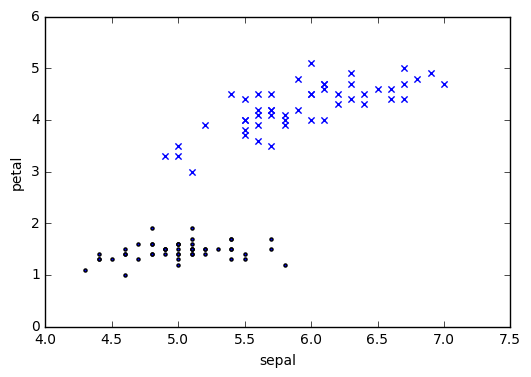

In [60]:
# plot the two species to show linear separation
%matplotlib inline
import matplotlib.pyplot as plt

def irisplot(X):
    plt.scatter(X[:50,1], X[:50,2], marker='.')
    plt.scatter(X[50:,1], X[50:,2], marker='x')
    plt.xlabel('sepal')
    plt.ylabel('petal')
    plt.show()
    
irisplot(X)

This shows the classes to be linearly separable: we can a draw straight line to separate the two classes.
In fact, we can draw many such lines.
The same concept applies to problems with more than two dimensions, with lines being replaced by hyperplanes.

### Predicting with the Perceptron

For linearly separable problems the Perceptron [1] can learn to identify the class for each observation $\bf x$ 
by learning a weight vector $\bf w$. By convention vectors are denoted in bold face, while individual
elements such as $x_0$ are denoted in normal mathematical font which is usually italics.

We prepared the data so that $x_0=1$ for all observations, $x_1$ is the sepal length
in the current observation, and $x_2$ is the petal length.
The weights $w_j$ will result from the learning rule and can take on any value. 

Once the weights are learned, the computation of the output is a simple dot product followed by a non-linearity:

$$
    o = 
    \begin{cases}
      1 & \text{if}\ {\bf x} \cdot {\bf w} \gt 0.5 \\
      0 & \text{otherwise}
    \end{cases}
$$

The dot product of vectors ${\bf x}$ and ${\bf w}$ is

$$ {\bf x} \cdot {\bf w} = \sum_j x_j w_j $$

With Numpy's `dot()` function
the performance of these computations is similar to programming the same algorithm in a statically compiled language such
as C, or a Just-In-Time compiled language such as Java. 

  
The perceptron can also be formulated as predicting classes encoded as -1 and 1, and using 0.0 rather than 0.5
for the non-linearity threshold. The version 
used here is chosen for consistency with the other approaches discussed later.

The first element $w_0$ of the weight vector is often termed the *bias* and denoted separately. However, incorporating
the bias into the weight vector makes the notation more concise.

The predict() function is used to generate a prediction on the observation $\bf x$ using the weights $\bf w$:

In [61]:
# predict class (0 or 1) of observation x from weight vector w 
def predict(x, w):
    return int(np.dot(x, w) > 0.5 )

Given a suitable weight vector the Perceptron predicts the correct
classes for the observations; X[0] is indeed a setosa, and X[50] is a versicolor:

In [62]:
w = [0.01, 0.07, 0.05]

print X[0]
print predict(X[0], w)

print X[50]
print predict(X[50], w)

[ 1.   5.1  1.4]
0
[ 1.   7.   4.7]
1


### The Perceptron Learning Rule

The Perceptron starts with weights all zero. During learning
the observations are used to provide updates for the weights.
In the simple implementation below learning stops after a specified number of epochs.

During each epoch all observations are processed sequentially; for each observation
the learning rule provides a small correction for $w_j$ based on the 
error of target value $y$ versus output $o$:

$$ \Delta w_j = \eta ~ (y - o) ~ x_j $$

In vector notation this becomes

$$ {\Delta\bf w} = \eta ~ (y - o) ~ {\bf x} $$

These values are used to update the weights:

$$ 
{\bf w} := {\bf w} + {\bf\Delta w} 
$$



This learning rule is implemented in the code below. Because of the automatic element-wise operations
of Numpy arrays we can update the complete weight vector in one statement; looping over the individual
elements is not necessary.
At the end of each epoch
we plot the number of false classifications.

In [63]:
# Perceptron
def percep(X, y, epochs, eta):
    r, c = len(X), len(X[0])
    w = np.zeros(c)
    for ep in range(epochs):
        # for each sample: calculate error, update weights
        for i in range(r):
            w += eta * (y[i] - predict(X[i], w)) * X[i]
        # number of misclassified
        print sum([ (y[i] != predict(X[i], w)) for i in range(r) ]), 
    print ""
    return w

The learning rate $\eta$ has to be chosen wisely, depending on the problem. 

In the example below the perceptron converges quickly and separates the two classes with 0 errors.

In [64]:
# convergence after a few epochs
percep(X, y, 10, 0.02)

50 50 0 0 0 0 0 0 0 0 


array([ 0.   ,  0.046,  0.118])

Unfortunately, the domain of linearly separable problems is rather limited, and many practical applications
cannot be solved by the perceptron, such as the separation of the Iris species versicolor and virginica:

In [65]:
# select data for versicolor & virginica
X, y = nonsep
print X[:3]
print y[:3]
print X[-3:]
print y[-3:]
print len(X), len(y)

[[ 1.   7.   4.7]
 [ 1.   6.4  4.5]
 [ 1.   6.9  4.9]]
[0 0 0]
[[ 1.   6.5  5.2]
 [ 1.   6.2  5.4]
 [ 1.   5.9  5.1]]
[1 1 1]
100 100


This subset of the data again contains 50 observations for each species.
A scatter plot shows that we cannot draw a straight line to separate the data points of the two species:

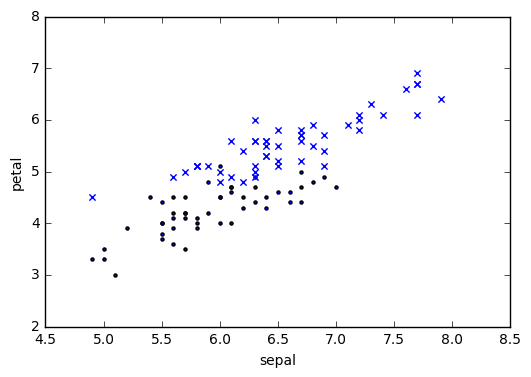

In [66]:
# these two classes are not linearly separable
irisplot(X)

No matter what values we choose for learning rate and number of epochs, the perceptron will not converge to a solution
with 0 errors.

In [67]:
# no convergence
percep(X, y, 200, 0.0001)

50 20 23 20 23 18 22 18 19 22 18 22 18 18 18 18 16 18 18 18 17 18 17 19 18 18 18 18 16 17 18 17 18 16 17 15 17 18 17 18 14 17 18 17 18 14 18 13 16 18 13 18 13 17 12 15 18 13 17 12 16 12 13 16 12 16 12 16 12 13 15 12 15 12 15 12 13 12 12 14 12 14 12 13 12 13 11 13 14 12 14 11 12 11 12 11 12 11 12 9 12 14 11 14 10 14 10 12 9 12 9 11 8 11 8 11 8 11 8 11 8 11 8 11 8 11 8 10 9 10 9 10 9 10 9 10 9 10 9 10 9 10 9 10 9 10 9 10 9 10 9 10 9 10 9 10 9 8 9 8 9 8 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 8 9 8 9 8 9 8 9 8 6 8 6 9 7 9 7 9 7 6 8 7 


array([ 0.018  ,  0.00601,  0.09307])

### The Adaptive Linear Neuron

After the Perceptron was introduced a modified algorithm was formulated that
uses an explicit optimisation of a cost function,
the Adaptive Linear Neuron [2]. For prediction the non-linearity is applied to the activations
in the same manner as with the perceptron, but for the purpose of learning the activation vector
${\bf a}$
is used i.e. the inner product of weight vector ${\bf w}$ and feature vector ${\bf x}$.

A cost function is specified that measures
the quality of the solution by taking a sum of squares,
similar to the sum of squared errors in OLS linear regression:

$$ J({\bf w}) = 1/2 \sum_i (y^{(i)} - a^{(i)})^2 $$

where $y^{(i)}$ denotes the actual class of observation i, and $a^{(i)}$ denotes the activation 
based on the the i-th observation.
The cost function measures the errors of the $a^{(i)}$ versus the $y^{(i)}$.

This function is minimised with a **gradient descent** i.e. the weights are updated in the direction
that decreases the value of the cost function. This can be done easily since
this cost function has a simple partial derivative for $w_j$ which turns out to be

$$ \frac{\partial J}{\partial w_j} = \sum_i (y^{(i)} - a^{(i)}) (-x^{(i)}_j) $$

The weight update is applied on the combined
error of ${\it all}$ observations, not after each individual observation as with the Perceptron:

$$ \Delta w_j = \eta \sum_i (y^{(i)} - a^{(i)}) x^{(i)}_j $$

However, since ${\bf X}$ is the matrix containing all feature vectors as rows we can compute the
activation $a_i$ as

$$ a_i = {\bf X}_i \cdot {\bf w}$$

where ${\bf X}_i$ denotes line $i$ of matrix ${\bf X}$. 
This means that we can compute the complete activation vector as 

$$ {\bf a} = {\bf X w}$$

The term ${\bf X w}$ denotes the matrix-vector product of matrix $\bf X$ with $r$ rows and $c$ columns, 
and vector $\bf w$ whose length has to be equal to $c$. The result is a vector of length $r$,
the activations for all observations.

Therefore, the complete vector of errors is

$$ {\bf y} - {\bf X} {\bf w} $$

which we need to multiply with the $x_j$ value for each observation and sum over $i$; 
this is achieved by another matrix-vector product:

$$ {\bf X}^T ({\bf y} - {\bf X} {\bf w}) $$

where ${\bf X}^T$ denotes the transpose of ${\bf X}$.
The complete weight update is

$$ {\bf \Delta w} = \eta {\bf X}^T ({\bf y} - {\bf X} {\bf w}) $$



Thanks to Numpy this neat notation translates directly into Python code. 
The predict() function remains unchanged. 

In [68]:
# adaptive linear neuron
def adaline(X, y, epochs, eta):
    r, c = len(X), len(X[0])
    w = np.zeros(c)
    for ep in range(epochs):
        # error = target - activation 
        err = y - np.dot(X, w) 
        # batch update based on all samples
        w += eta * np.dot(X.T, err)
        # predict same as with perceptron
        print sum([ predict(X[i], w) != y[i] for i in range(r) ]) ,
    print ""
    return w

X, y = nonsep
adaline(X, y, 100, 0.0003)

50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 49 50 49 50 47 49 47 46 45 43 44 42 43 36 42 30 40 25 36 22 34 21 31 19 29 15 23 14 22 12 22 10 21 10 18 9 17 7 16 6 14 5 13 5 13 6 12 6 11 6 9 5 9 5 9 5 8 5 8 5 8 6 8 6 8 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 


array([-0.07360328, -0.14812973,  0.30922981])

The adaline() algorithm only converges with a suitable choice of learning rate:

In [69]:
# eta too large: gradient descent overshoots minimum and diverges
adaline(X, y, 100, 0.0004)

50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 


array([ -3.73657355e+18,  -2.36849440e+19,  -1.86879168e+19])

In [70]:
# eta too small: gradient descent takes longer
adaline(X, y, 200, 0.0001)

50 24 19 22 22 23 23 23 23 21 21 21 21 21 21 21 21 21 20 20 20 20 19 19 19 19 19 19 19 18 18 18 18 18 17 17 16 16 16 15 15 15 15 15 15 15 15 15 15 14 14 14 14 14 14 14 14 14 13 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 11 11 11 11 10 10 10 10 10 10 10 10 10 10 10 10 10 10 8 8 8 8 8 8 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 


array([-0.04957726, -0.09089419,  0.23320326])

In [71]:
# check convergence for linearly separable problem
X, y = sep
adaline(X, y, 10, 0.0001)

50 48 12 4 0 0 0 0 0 0 


array([ 0.00764805,  0.05938836,  0.07788378])

### Stochastic Gradient Descent

In recent years a number of improvements were made to the machine learning approaches discussed here which led to renewed
interest in the field under the term Deep Learning. One of these improvements is the realisation that it is not neccessary
to run through all observations before an update is made; only a small number of errors is enough to provide an useful update
for the gradient search. This technique is called stochastic gradient descent. It provides a huge speedup to the learning
process and usually results in similar convergence towards the optimal solution.

In [72]:
# adaptive linear neuron with stochastic gradient descent
def adalinesgd(X, y, epochs=20, eta=0.0001):
    # shuffle dataset
    ix = np.random.permutation(len(X))
    X, y = X[ix], y[ix]
    r, c = len(X), len(X[0])
    w = np.zeros(c)
    for ep in range(epochs):
        # shuffle sample 
        for i in np.random.permutation(r):
            # update weights after each sample
            err = y[i] - np.inner(X[i], w) 
            w += eta * X[i] * err 
        # predict same as with perceptron
        print sum([ predict(X[i], w) != y[i] for i in range(r) ]) ,
    print ""
    return w

# linearly separable problem
X, y = sep
np.random.seed(4217)
adalinesgd(X, y, 10, 0.0001)

50 50 34 9 4 1 0 0 0 0 


array([ 0.00752945,  0.05865187,  0.07733068])

In [73]:
# non-separable problem
X, y = nonsep
adalinesgd(X, y, 100, 0.0003)

37 18 17 25 19 24 12 15 12 23 11 22 19 8 27 25 9 13 10 12 15 8 10 7 8 6 7 19 15 20 9 6 16 7 9 7 21 20 10 4 5 7 5 8 4 4 6 4 4 7 6 11 5 5 4 4 11 5 5 5 5 12 10 12 5 5 5 8 5 5 13 6 5 6 6 6 5 8 5 6 5 6 6 6 4 6 6 6 6 6 6 6 5 6 5 6 6 10 5 6 


array([-0.07378352, -0.14828429,  0.31057101])

In [74]:
# MNIST dataset
import cPickle, gzip, numpy

# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

In [75]:
img, lab = train_set
# pick cases with label 0 or 1 
ix = [ i for i in range(len(lab)) if lab[i] in (0, 1) ]
X = np.array(img[ix])
y = np.array(lab[ix])

# shuffle dataset
ix = np.random.permutation(len(X))
X, y = X[ix], y[ix]

print "rows & cols in train set:", len(X), len(X[0]), "   first label:", y[0], "first image:"
print "\n".join( [ " ".join([ ".*"[int(X[0][j + i*28] > 0.5)] for j in range(28) ]) for i in range(28) ] )
print "first 100 labels:", y[:100]

rows & cols in train set: 10610 784    first label: 0 first image:
. . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . * * * * . * * * . . . . . . . .
. . . . . . . . . . . . * * * * * * * * * * . . . . . .
. . . . . . . . . . . * * * * * * * * * * * . . . . . .
. . . . . . . . . . * * * * . . . . . * * * . . . . . .
. . . . . . . . . * * * * . . . . . . . * * * . . . . .
. . . . . . . . . * * * . . . . . . . . * * * . . . . .
. . . . . . . . * * * * . . . . . . . . * * * . . . . .
. . . . . . . . * * * * . . . . . . . . * * * . . . . .
. . . . . . . . * * * * . . . . . . . . * * * . . . . .
. . . . . . . * * * * . . . . . . . . . * * * . . . . .
. . . . . . . * * * * . . . . . . . . . * * * . . . . .
. . . . . . . * * * * . . . . . . . . * * * * . . . . .
. . . . . . . * * * . . . . . . . . .

In [76]:
w = adalinesgd(X, y, 60, 0.0001)

lw = 0.001
print 'display weights at work:'
print len([ x for x in w if abs(x) > lw ]), "weights with abs(w) >", lw
wd = np.array([ 'o' for i in range(len(w)) ])
wd[ (w < 0) & (abs(w) > lw) ] = '-'
wd[ (w > 0) & (abs(w) > lw) ] = '+'
print "\n".join( [ " ".join([ wd[j + i*28] for j in range(28) ]) for i in range(28) ] )

103 99 95 95 94 94 98 97 100 98 101 99 99 101 100 100 99 100 103 101 101 103 103 102 103 103 106 105 106 106 106 106 107 107 106 108 108 106 108 109 109 105 111 110 108 109 109 107 108 105 109 107 106 109 107 111 108 107 107 108 
display weights at work:
437 weights with abs(w) > 0.001
o o o o o o o o o o o o o o o o o o o o o o o o o o o o
o o o o o o o o o o o o o o + + o o o o o o o o o o o o
o o o o o o o o o o o o + + + + + + + + o o o o o o o o
o o o o o o o o o o o + + + + + + + + + + + o o o o o o
o o o o o + o - o + + + + + + + o + + - + + + + + o o o
o o o o o + + - + + o - - + o + + + + + + + + + + o o o
o o o o o o + o o + - + + + + - o + o - + + + + + o o o
o o o o + + + + o - - - + - + + + + - + o + - - - o o o
o o o o + + o o + - - o o + + o + o + + - - - - - o o o
o o o o + + - + + + - + o + + o + + + - - - - - - o o o
o o o o + + - - o + o + o - + - + + - o o - - - - + o o
o o o - + + - - - - o - + - + + - + o - - - - o - + o o
o o o - + o - + - + + - - - + + - - - - -

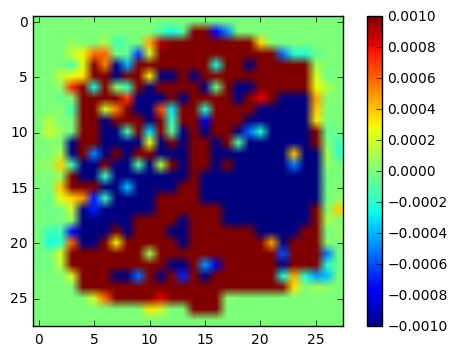

In [77]:
import matplotlib as mpl
import matplotlib.cm as cm

wm = [ [ w[i*28+j] for j in range(28) ] for i in range(28) ]
fig, ax = plt.subplots()
im = ax.imshow(wm, vmin=-0.001, vmax=0.001 )
fig.colorbar(im)
plt.show()

In [78]:
def softpred(X, W):
    scor = np.dot(X, W)
    escor = np.exp(scor)
    return escor / np.sum(escor, axis=1, keepdims=True)

In [79]:
# % false classifications
def erate(probs, y):
    return '%.1f' % ((100.0 * sum(y != [ np.argmax(pr) for pr in probs ])) / len(y))

In [80]:
def linsoftmax(X, y, stepsize=0.5, steps=50):
    D = len(X[0])
    K = len(set(y)) # number of classes
    W = 0.01 * np.random.randn(D,K)
    #b = np.zeros((1,K))
    for step in range(steps):
        #scor = np.dot(X, W) + b
        #escor = np.exp(scor)
        probs = softpred(X, W) # escor / np.sum(escor, axis=1, keepdims=True)
        # print % false classifications
        if (step % 10) == 0: print erate(probs, y),  
        # gradient
        dscor = probs
        dscor[range(len(y)), y] -= 1
        dscor /= len(y)
        dW = np.dot(X.T, dscor)
        #db = np.sum(dscor, axis=0, keepdims=True)
        dW += 0.001 * W
        # parameter update in the negative gradient direction to decrease loss
        W += -stepsize * dW
        #b += -stepsize * db
    print '\nerror on train set:', erate(softpred(X, W), y)
    return W

W = linsoftmax(X, y)

52.4 0.3 0.3 0.3 0.2 
error on train set: 0.2


In [81]:
def netpred(X, W, W2):
    # ReLU units in hidden layer
    hid = np.maximum(0, np.dot(X, W)) # input to hidden
    scor = np.dot(hid, W2)            # hidden to output
    escor = np.exp(scor)
    return escor / np.sum(escor, axis=1, keepdims=True), hid

In [82]:
# introduce hidden layer, SGD
def netsoftmax(X_, y_, h, stepsize=0.5, steps=50):
    reg = 0.001
    D = len(X_[0])
    K = len(set(y_)) # number of classes
    W = 0.1 * np.random.randn(D,h)
    #b = np.zeros((1,h))
    W2 = 0.1 * np.random.randn(h, K)
    #b2 = np.zeros((1,K))
    for step in range(steps):
        # SGD
        ix = np.random.choice(len(y_), min(200, len(y_)), replace=False)
        X, y = X_[ix], y_[ix]
        probs, hid = netpred(X, W, W2)
        if (step % 10) == 0: print erate(probs, y) , 
        # gradient
        dscor = probs
        dscor[range(len(y)), y] -= 1
        dscor /= len(y)
        # backprop to hidden layer
        dW2 = np.dot(hid.T, dscor)
        #db2 = np.sum(dscor, axis=0, keepdims=True)
        dhid = np.dot(dscor, W2.T)
        # hidden units pass through unless <= 0
        dhid[hid <= 0] = 0
        dW = np.dot(X.T, dhid)
        #db = np.sum(dhid, axis=0, keepdims=True)
        # regularization
        dW += reg * W
        dW2 += reg * W2
        # parameter update in the negative gradient direction to decrease loss
        W += -stepsize * dW
        #b += -stepsize * db
        W2 += -stepsize * dW2
        #b2 += -stepsize * db2
    # print % false classifications on complete X
    probs, hid = netpred(X_, W, W2)
    print '\nerror on train set: ', erate(probs, y_)
    return W, W2

W, W2 = netsoftmax(X, y, 100, steps=30)

48.0 0.5 0.0 
error on train set:  0.2


In [83]:
print 'TRAINING full MNIST..'
X, y = train_set
print 'len(y):', len(y)
print 'first 30 y: ', y[:30]

print 'linsoftmax:'
Wlin = linsoftmax(X, y, steps=30)

print 'netsoftmax:'
import time
start = time.time()
W, W2 = netsoftmax(X, y, 300, steps=500, stepsize=0.5)
print 'time elapsed:', time.time() - start

print('TESTING full MNIST..')
X, y = test_set

probs = softpred(X, Wlin)
print 'linsoftmax error on test set: ', erate(probs, y)

probs, hid = netpred(X, W, W2)
print 'netsoftmax error on test set:  ', erate(probs, y)

TRAINING full MNIST..
len(y): 50000
first 30 y:  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
linsoftmax:
89.0 16.5 14.2 
error on train set: 13.2
netsoftmax:
94.0 22.5 16.0 10.5 12.5 9.5 9.5 9.5 9.0 11.0 7.0 7.0 6.5 8.5 7.0 9.0 4.5 8.0 7.5 6.0 4.0 3.0 6.5 7.5 5.5 7.5 6.0 4.0 5.0 7.0 7.0 5.0 3.5 5.5 5.5 3.5 4.5 5.5 5.0 6.5 8.5 4.0 7.0 4.0 3.5 3.0 3.5 4.5 3.5 3.0 
error on train set:  4.0
time elapsed: 5.44900012016
TESTING full MNIST..
linsoftmax error on test set:  12.0
netsoftmax error on test set:   4.5


In [84]:
import sys
print(sys.version)

2.7.12 |Anaconda 4.2.0 (64-bit)| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


### References

<p class="bib">
[1] F. Rosenblatt. The perceptron, a perceiving and recognizing automaton (Project Para). 
   Report 85-460-1, Cornell Aeronautical Laboratory, 1957.

<p class="bib">
[2] B. Widrow et al. Adaptive ”Adaline” neuron using chemical ”memistors”. Technical Report 1553-2, 
    Stanford Electronics Laboratories, 1960. 

<p class="bib">
[3] S. Raschka. Single-Layer Neural Networks and Gradient Descent.        http://sebastianraschka.com/Articles/2015_singlelayer_neurons.html

<p class="bib">
[4] Convolutional Neural Networks for Visual Recognition. 
http://cs231n.github.io/neural-networks-case-study/

<p class="bib">
[5] UCI Machine Learning Repository, Iris Data Set.
https://archive.ics.uci.edu/ml/datasets/Iris